<a href="https://colab.research.google.com/github/riazzzz/softcomp/blob/main/assignment2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from google.colab import drive
from PIL import Image, ImageOps, ImageEnhance
from sklearn.linear_model import LinearRegression

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters

batch_size = 20
num_iters = 25000
input_dim = 180*180 # num_features = 784
output_dim = 10

learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def my_collate(batch):
    data = torch.stack([item[0] for item in batch])
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]



In [ ]:
class newDataset(Dataset):


    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digit_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.digit_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.digit_frame.iloc[idx, 0])
        image = Image.open(img_name)

        image=image.point(lambda p: abs(255-p))

        #image = ImageOps.invert(image)
        #enhancer = ImageEnhance.Contrast(image)
        #image = enhancer.enhance(1.1)
        t=15
        image=image.point(lambda p: p > t and 255)
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(1.2)
        #enhancer = ImageEnhance.Contrast(image)
        #image = enhancer.enhance(2)
        #image=image.point(lambda p: p+20)
        #image=image.point(lambda p: p > t and 255)




        #np_array = np.array(image)
        #np_array = np_array*(.5)
        #image=Image.fromarray(np_array)


        #image=image.point(lambda p: p)
        #image=np.array(image)
        digit = self.digit_frame.iloc[idx, 1:]
        digit = np.array([digit])
        dig=digit[0][0].item()
       # digit = digit.astype('float').reshape(-1, 2)
        #sample = {'image': image, 'digit': digit}

        if self.transform:
           image = self.transform(image)
           sample = {'images': image, 'labels': digit}
        return (image,dig)



```
# This is formatted as code
```

### Loading  Dataset

In [ ]:
transform = transforms.Compose([
                                # transforms.ToPILImage(),

                                ## this is only for when model is 1
                                transforms.Grayscale(), 
                                

                               # transforms.Resize(28),  ## image resize
                                #transforms.CenterCrop(28), ## image center crop
                                transforms.ToTensor(),
                                #transforms.functional.invert(),
                                ## array converted into torch tensor and then divided by 255 (1.0/255)
                                 #transforms.Normalize([.5] , [.5])
                               ])





'''
LOADING DATASET
'''
dset=newDataset(csv_file='/content/drive/MyDrive/4238data/trainc/training-c.csv',root_dir='/content/drive/MyDrive/4238data/trainc/training-c',transform=transform)
train_dataset,test_dataset = torch.utils.data.random_split(dset,[20000,4298])
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
'''
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           collate_fn=my_collate)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,collate_fn=my_collate)  



In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(num_epochs)
train_dataset

20000
4298
25


In [ ]:
# Inspecting a single image (28 pixel x 28 pixel) -->  28x28 matrix of numbers

#train_dataset[0]

In [ ]:
# One Image Size
#print(train_dataset[0][0].show())
print(train_dataset[0][0].size())
print(train_dataset[0][0].numpy().shape)
# First Image Label
print(train_dataset[0][1])
type(train_dataset[0][1])
#display(train_dataset[0][0])


torch.Size([1, 180, 180])
(1, 180, 180)
3


int

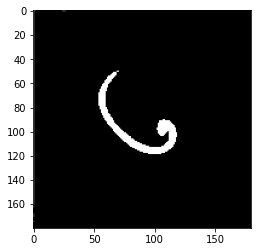

In [ ]:
## Displaying a MNIST Image

import matplotlib.pyplot as plt 
import numpy as np

show_img = train_dataset[0][0].numpy().reshape(180, 180)
plt.imshow(show_img, cmap='gray')

Label:
0


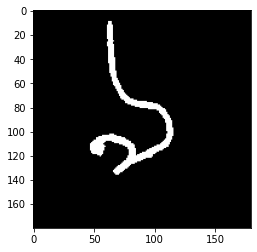

In [ ]:
# Displaying another MNIST Image
# Label
print("Label:")
print(train_dataset[2][1])

show_img = train_dataset[22][0].numpy().reshape(180, 180)
plt.imshow(show_img, cmap='gray')

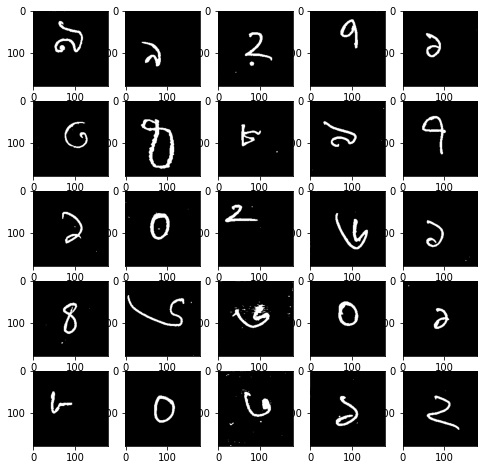

In [ ]:
# Displaying another MNIST Image
# Label

import random
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = train_dataset[i+random.randint(1, 18000)][0].numpy().reshape(180, 180)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()

### Step #1 : Design your model using class

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 180)#100 gave 76%accuracy
        self.fc2 = nn.Linear(180, 24)
        
     
        self.fc7 = nn.Linear(24, num_classes)

    def forward(self, x):
        x = x.view(-1, 180* 180) 
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        
        
        logits  = self.fc7(x)

        probas = F.softmax(logits, dim=1)
        return [logits, probas]

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (fc1): Linear(in_features=32400, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=24, bias=True)
  (fc7): Linear(in_features=24, out_features=10, bias=True)
)

###Step #2 : Construct loss and optimizer (select from PyTorch API)

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

###Step #3 : Training: forward, loss, backward, step

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
accuracy_increase= []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
        #labels =labels.flatten()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 
       # print(logits)
       # print(probas)
        #print(labels)
        

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
                labels = labels.to(device)
               # labels =labels.flatten()
                

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)
                print(correct)
                print(total)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            accuracy_increase.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Streaming output truncated to the last 5000 lines.
tensor(1422)
1740
tensor(1439)
1760
tensor(1456)
1780
tensor(1472)
1800
tensor(1490)
1820
tensor(1506)
1840
tensor(1523)
1860
tensor(1541)
1880
tensor(1557)
1900
tensor(1574)
1920
tensor(1587)
1940
tensor(1607)
1960
tensor(1623)
1980
tensor(1643)
2000
tensor(1660)
2020
tensor(1677)
2040
tensor(1695)
2060
tensor(1712)
2080
tensor(1729)
2100
tensor(1745)
2120
tensor(1763)
2140
tensor(1780)
2160
tensor(1797)
2180
tensor(1813)
2200
tensor(1828)
2220
tensor(1846)
2240
tensor(1863)
2260
tensor(1878)
2280
tensor(1895)
2300
tensor(1911)
2320
tensor(1926)
2340
tensor(1943)
2360
tensor(1958)
2380
tensor(1975)
2400
tensor(1988)
2420
tensor(2000)
2440
tensor(2016)
2460
tensor(2033)
2480
tensor(2049)
2500
tensor(2064)
2520
tensor(2078)
2540
tensor(2095)
2560
tensor(2112)
2580
tensor(2130)
2600
tensor(2149)
2620
tensor(2168)
2640
tensor(2186)
2660
tensor(2204)
2680
tensor(2222)
2700
tensor(2236)
2720
tensor(2253)
2740
tensor(2269)
2760
tensor(2286)


[1.8375794887542725, 1.9225099086761475, 1.3626680374145508, 1.5517669916152954, 1.258105754852295, 1.3233462572097778, 0.8365537524223328, 0.6055151224136353, 0.5314797163009644, 0.37574321031570435, 0.47223371267318726, 0.1550339162349701, 0.41911402344703674, 0.2890073359012604, 0.23936155438423157, 0.2917715013027191, 0.061283648014068604, 0.13714587688446045, 0.08043619990348816, 0.10582147538661957, 0.12349022924900055, 0.02835002914071083, 0.08454868942499161, 0.043443720787763596, 0.02142944559454918, 0.11236004531383514, 0.016585860401391983, 0.01675303652882576, 0.012145161628723145, 0.01119829248636961, 0.01677977479994297, 0.013146338984370232, 0.005856351926922798, 0.00988259632140398, 0.006387376692146063, 0.010670999065041542, 0.006966101936995983, 0.005820595659315586, 0.003422135952860117, 0.0020239895675331354, 0.005017764400690794, 0.007191159762442112, 0.007067450787872076, 0.0060033854097127914, 0.020462989807128906, 0.005992261227220297, 0.002768243895843625, 0.00

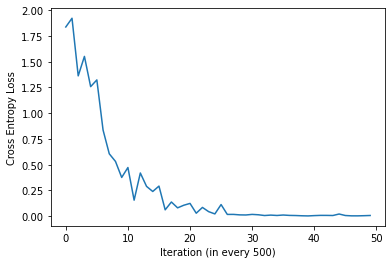

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

[33.99255467659376, 43.20614239181015, 52.256863657515126, 57.561656584457886, 64.77431363424849, 68.28757561656585, 71.1493718008376, 72.49883666821778, 74.05770125639833, 75.96556537924616, 77.1986970684039, 78.5248953001396, 79.10656119125174, 79.45556072591903, 79.19962773382969, 80.38622615169847, 80.71195905072126, 80.13029315960912, 81.54955793392276, 81.9683573755235, 82.43369008841321, 82.01489064681247, 81.82875756165659, 82.01489064681247, 82.59655653792461, 82.43369008841321, 82.66635644485807, 82.75942298743601, 82.87575616565844, 83.08515588645882, 83.03862261516984, 83.20148906468124, 83.08515588645882, 83.24802233597022, 82.99208934388088, 83.15495579339228, 83.15495579339228, 83.17822242903677, 83.06188925081433, 83.20148906468124, 83.34108887854816, 83.34108887854816, 83.31782224290367, 83.29455560725918, 83.27128897161471, 83.34108887854816, 83.20148906468124, 83.27128897161471, 83.27128897161471, 83.20148906468124]


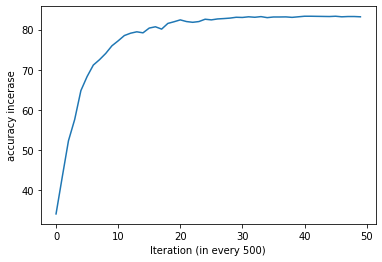

In [ ]:


print (accuracy_increase)
plt.plot(accuracy_increase)
plt.ylabel('accuracy incerase')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/4238data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save Model

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'logistic81accu1node1hidden.pkl') 

### Load Model

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'logistic81accu1node1hidden.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


### Testing Loaded Model with Digits

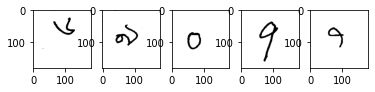

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(180, 180), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 180*180).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [6 9 0 4 7]
